In [94]:
import pandas as pd
import seaborn as sns
import json
import os
import sys
import matplotlib.pyplot as plt
sys.path.append("..")

In [53]:
def linear_dict(d, prefix="", new_d=None):
    if new_d is None:
        new_d = {}
    for k, v in d.items():
        if isinstance(v, dict):
            linear_dict(v, prefix + k + "_", new_d)
        else:
            new_d[prefix + k] = v
    return new_d

def linear_dicts_from_file(f_name):
    dicts = []
    with open(f_name) as f:
        for line in f:
            d = json.loads(line)
            dicts.append(linear_dict(d))
    return dicts

def stack_dfs_subdirs(path, f_name):
    ds = []
    for d in os.listdir(path):
        path_d = os.path.join(path, d)
        path_d_f = os.path.join(path, d, f_name)
        if os.path.isdir(path_d) and os.path.exists(path_d_f):
            ds.extend(linear_dicts_from_file(path_d_f))
    return pd.DataFrame(ds)

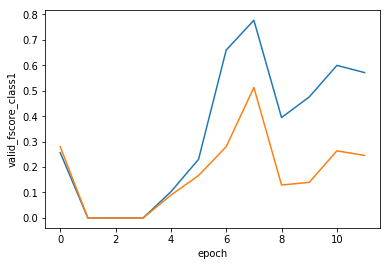

In [68]:
df = pd.DataFrame(linear_dicts_from_file("../results/out_train_20191126-200229-350501/res_perepoch.json"))
sns.lineplot(x="epoch", y="train_fscore_class1", data=df)
sns.lineplot(x="epoch", y="valid_fscore_class1", data=df)

## Find LR
Testes com método para encontrar melhor LR de acordo com [este artigo](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)
    que explica a técnica usada na biblioteca **fastai**.

Escolhemos **LR=0.01 (1e-2)**

(0.3751726164732568, 1.406475650998201)

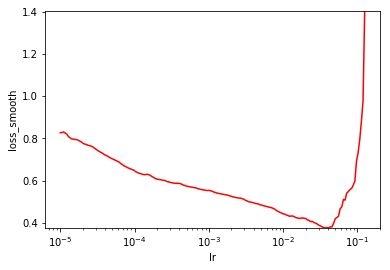

In [118]:
df = pd.DataFrame(linear_dicts_from_file("../results/out_train_20191126-200229-350501/res_periter.json"))

# smoothing
df["loss_smooth"] = df["loss_iter"].ewm(alpha=0.02).mean()

min_loss = df["loss_smooth"].min()
df = df[df["loss_smooth"] < 4 * min_loss]

# sns.lineplot(x="lr", y="loss_iter", data=df)
p = sns.lineplot(x="lr", y="loss_smooth", data=df, color="r")
p.set(xscale="log")

import matplotlib.pyplot as plt
# ay2 = plt.twiny()
# sns.lineplot(x="epoch", y=0, data=df, ax=ay2, color="w")

plt.ylim(df["loss_smooth"].min(),df["loss_smooth"].max())

## Shuffle Split CV num_splits=5

(0.3, 0.6)

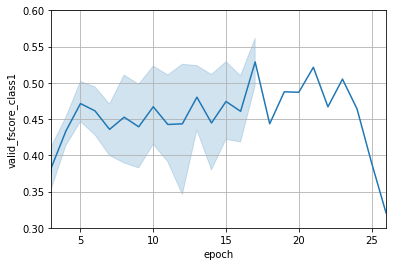

In [112]:
df = stack_dfs_subdirs("../results/out_cv_shuffle_split_20191127-090041-371483/", "res_perepoch.json")
# sns.lineplot(x="epoch", y="train_fscore_class1", data=df)
sns.lineplot(x="epoch", y="valid_fscore_class1", data=df)
plt.grid(True)
plt.xlim(3,26)
plt.ylim(0.3,0.6)

## Balanced Batches
Cada batch contém o mesmo número de exemplos positivos e negativos.

**Aparentemente, isto acelerou bastante a convergência do treino.**

(0.3, 0.6)

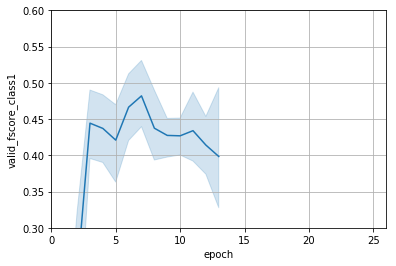

In [113]:
df = stack_dfs_subdirs("../results/out_cv_shuffle_split_20191127-084720-471141/", "res_perepoch.json")
# sns.lineplot(x="epoch", y="train_fscore_class1", data=df)
sns.lineplot(x="epoch", y="valid_fscore_class1", data=df)
plt.grid(True)
plt.xlim(0,26)
plt.ylim(0.3,0.6)

## Stratified Splits
Além de usar balanced batches,
    usamos também splits estratificados, isto é,
        durante a geração dos splits train/valid,
            a proporção entre as classes é mantida.
          
Isto não parece ter afetado os resultados.   

In [ ]:
df = stack_dfs_subdirs("../results/out_cv_shuffle_split_20191124-224054-548909/", "res_perepoch.json")
sns.lineplot(x="epoch", y="train_fscore_class1", data=df)
sns.lineplot(x="epoch", y="valid_fscore_class1", data=df)

## Stratified Splits w/out Balanced Sampler
Neste experimento,
    usamos splits estratificados
        mas não usamos o balanced sampler.
Foram executadas 20 runs.

In [ ]:
df = stack_dfs_subdirs("../results/out_cv_shuffle_split_20191125-095226-007125/", "res_perepoch.json")

# find max epoch for which at least half of the splits have run to
epoch_max = df.epoch.max()
dfs = []
gby = df.groupby("split")
for epoch_up in range(epoch_max):
    if (gby.epoch.max() > epoch_up).sum() < epoch_max / 2:
        break

sns.lineplot(x="epoch", y="train_fscore_class1", data=df[df.epoch <= epoch_up])
sns.lineplot(x="epoch", y="valid_fscore_class1", data=df[df.epoch <= epoch_up])

## Stratified Batch Sampler
Neste experimento,
    usamos um stratified batch sample, ou seja,
        cada batch do treinamento tem a mesma proporção de classes do split de treino todo.
Foram executadas 20 runs.

In [ ]:
df = stack_dfs_subdirs("../results/out_cv_shuffle_split_20191125-095226-007125/", "res_perepoch.json")

# find max epoch for which at least half of the splits have run to
epoch_max = df.epoch.max()
dfs = []
gby = df.groupby("split")
for epoch_up in range(epoch_max):
    if (gby.epoch.max() > epoch_up).sum() < epoch_max / 2:
        break

df = df[df.epoch <= epoch_up]

sns.lineplot(x="epoch", y="train_fscore_class1", data=df)
sns.lineplot(x="epoch", y="valid_fscore_class1", data=df)